In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN

In [2]:
# Paths to unprocessed dataset files
prefix = '../data/'
filePaths = {
    "reviews": prefix + 'yelp_academic_dataset_review.json',
    "businesses": prefix + 'yelp_academic_dataset_business.json',
    "checkins": prefix + 'yelp_academic_dataset_checkin.json',
    "tips": prefix + 'yelp_academic_dataset_tip.json',
    "users": prefix + 'yelp_academic_dataset_user.json'
}

# General overview of this notebook:
---

This notebook uses our labeled restaurant categories identified by TF-IDF and K-Means clustering to investigate to questions for our project:

**(1) What restaurant categories are frequently reviewed by Yelp users with low and high review counts?**

**(2) Do restaurants with high and low average star review cluster around specific locations in the city?**

The information gained from these questions can be useful when opening restaurants in Las Vegas: 

1. Knowing what restaurants are most frequently reviewed by different types of Yelp users (e.g. casual versus regular reviewers) can gauge what is currently popular in the city.


2. The locations of high star reviewed restaurant clusters can assist the restuarant owner in avoiding competition, or opening in a location with a better reputation.

## Load our cleaned and labeled restaurant data
---

#### IMPORTANT NOTE:

This notebook requires a json file in the Analysis directory: 

`Analysis/labeled_cleaned_restaurants.json` 

If it does not exist, it can be generated by running two notebooks in order:

(1) The cleaned restaurant json created by running notebook:
    
   `Preprocessing/Data Reduction/DataReduction_Businesses.ipynb`
        
(2) The labeled restaurant json from running notebook:
         
   `Analysis/restaurant_classification.ipynb`
   
The user data is assumed unprocessed and is read from the `data/` directory.


In [3]:
%%time

# Load the labeled business json
PATH = os.path.abspath(os.path.dirname('__file__') + "labeled_cleaned_restaurants.json")
labeledRestaurants = pd.read_json(PATH, orient='records')

CPU times: user 101 ms, sys: 20.3 ms, total: 121 ms
Wall time: 120 ms


## Remove reviews that are not associated with our restaurants
---
This code filters our review data by removing reviews that are **not** associated with our cleaned and labeled restaurant business_id's. 

It is adapated from Daniel's preprocessing work.

In [4]:
%%time
# --------------------------------------------------------------------------
#  Filter reviews for our cleaned and labeled restaurants
# --------------------------------------------------------------------------

# Load the review json
reviewReader = pd.read_json(
    filePaths['reviews'], 
    lines=True,
    chunksize=1000
)

# Filter reviews using the business_id from our cleaned business json
chunk_list = []
for reviewChunk in reviewReader:
    reviewChunk = pd.merge(
        labeledRestaurants[['business_id']], 
        reviewChunk, 
        on='business_id', 
        how='inner'
    )
    chunk_list.append(reviewChunk)

# Merge chunks into a single dataframe
filtered_reviews = pd.concat(chunk_list, ignore_index=True, axis=0)

# Print how many reviews were extracted from the original dataset
print(f'found: {len(filtered_reviews)} reviews')

found: 831370 reviews
CPU times: user 2min 43s, sys: 2.55 s, total: 2min 46s
Wall time: 2min 47s


## Remove users that have not reviewed our restaurants
---

This code filters our user data by removing users that have **not** reviewed any of our cleaned and labeled restaurants.

It is adapated from Daniel's preprocessing work.

In [5]:
%%time
# --------------------------------------------------------------------------
# Select users who have reviewed our cleaned and labeled restaurants
# --------------------------------------------------------------------------

# Remove duplicate user ids from filtered reviews
filtered_reviews = filtered_reviews.drop_duplicates(subset='user_id')

# Load the user json
userReader = pd.read_json(
    filePaths['users'], 
    lines=True,
    chunksize=1000
)

# Filter the users json using user_id's from our filtered reviews dataset
chunk_list = []
for userChunk in userReader:
    userChunk = pd.merge(
        filtered_reviews[['user_id']], 
        userChunk, 
        on='user_id', 
        how='inner'
    )
    chunk_list.append(userChunk)

# Merge chunks into a single dataframe
filtered_users = pd.concat(chunk_list, ignore_index=True, axis=0)

# Print how many users were extracted from the original dataset
print(f'found: {len(filtered_users)} reviewers')

found: 365795 reviewers
CPU times: user 6min 54s, sys: 2.24 s, total: 6min 57s
Wall time: 6min 59s


# Group users by their review counts
---

Up to this point, we now have two dataframes: 

1. `filtered_users` contains users that have reviewed our restaurants 
2. `filtered_reviews` contains the reviews associated with our restaurants.

#### GOAL:

* Group users by their review counts
* Four groups: low, moderate, high, very high

#### WHY:

* We can look at differences in each group
* For example: Do high review count users submit Yelp reviews for certain restaurant categories more frequently that low review count users?

#### WORKFLOW:

1. Review counts are skewed towards 0 to 10 reviews per user, so perform a logarithmic transformation and group users using quartiles.
2. Review the dispersion of users review counts in each group using boxplots. Remove outliers if necessary.
3. Identify the restaurant categories reviewed by users in each group.
4. Use histograms to plot the frequency that each restaurant category is reviewed by users in each group.


## Logarithmic transofmration of review counts
---
This code transforms the review counts of all users in our `filtered_user` dataframe (i.e. those users who have reviewed restaurants in our cleaned and labeled restaurant data).

The log transform is plotted and review counts are separated into quantiles. Users are separated into their review count groups (low, moderate, high, very high) depending on which quantile their review count is in.

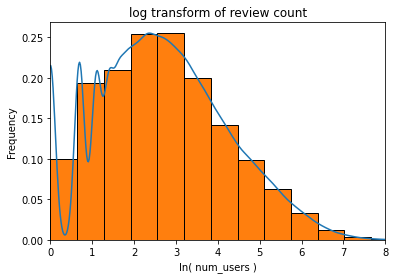

quantiles: | 25% 1.609 | 50% 2.565 | 75% 3.689 |


In [6]:
# --------------------------------------------------------------------------
#  Logarithmic transformation for user review counts
# --------------------------------------------------------------------------

# Log transform review counts
log_review_count = np.log(filtered_users['review_count'])

# Histogram figure settings
fig, ((ax0)) = plt.subplots(1, 1)

# review count plot
ax0.set_xlabel('ln( num_users )')
ax0.set_ylabel('num_reviews')
ax0.set_title('log transform of review count')
ax0.set_xlim([0.0, 8.0])

# Plot ln( num_users ) with kernel density estimation
log_review_count.plot(kind='kde')
log_review_count.plot(kind="hist", density=True, bins=15, ec='black')

# Show the plot
plt.show()

# --------------------------------------------------------------------------
#  Label review counts using quantiles
# --------------------------------------------------------------------------

# Compute quantiles:
q_25, q_50, q_75 = log_review_count.quantile(0.25), log_review_count.quantile(0.50), log_review_count.quantile(0.75)
print(f'quantiles: | 25% {round(q_25, 3)} | 50% {round(q_50, 3)} | 75% {round(q_75, 3)} |')

# Insert columns ['log_review_count']: log transformed review count values
if 'log_review_count' not in filtered_users:
    filtered_users.insert(3, 'log_review_count', log_review_count)

# Insert columns ['reviewer_type'] 
if 'reviewer_type' not in filtered_users:
    filtered_users.insert(4, 'reviewer_type', np.nan)

# Label the each user in the 'reviewer type' column based on the log_review_count quantile
# 0 to Q_25 : 'low', Q_25 to Q50: 'moderate', Q_50 to Q75: 'high', Q_75 and above: 'very_high'
quantile_conditions = [
    (filtered_users['log_review_count'] >= 0  ) & (filtered_users['log_review_count'] <= q_25),
    (filtered_users['log_review_count'] > q_25) & (filtered_users['log_review_count'] <= q_50),
    (filtered_users['log_review_count'] > q_50) & (filtered_users['log_review_count'] <= q_75),
    (filtered_users['log_review_count'] > q_75)
]
quantile_labels = ['low', 'moderate', 'high', 'very_high']
filtered_users['reviewer_type'] = np.select(quantile_conditions, quantile_labels)

# --------------------------------------------------------------------------
#  Separate users by review count ['low', 'moderate', 'high', 'very_high']
# --------------------------------------------------------------------------

# Create new dataframes for users grouped by review count
low_reviewers = filtered_users.loc[filtered_users['reviewer_type'] == 'low']
moderate_reviewers = filtered_users.loc[filtered_users['reviewer_type'] == 'moderate']
high_reviewers = filtered_users.loc[filtered_users['reviewer_type'] == 'high']
very_high_reviewers = filtered_users.loc[filtered_users['reviewer_type'] == 'very_high']

## Inspect the size of each review count group and the mean star review
---
This code just prints out the number of users that were placed into each group, and the mean star review for each group, using the method above.


In [7]:
# --------------------------------------------------------------------------
#  Print the size of each review count group and the mean star review
# --------------------------------------------------------------------------

print(f"""
review count group info:
{"--"*20}
n_low_reviewers = {len(low_reviewers)}  |  mean star review: {low_reviewers.average_stars.mean()}
n_moderate_reviewers = {len(moderate_reviewers)}  |  mean star review: {moderate_reviewers.average_stars.mean()}
n_high_reviewers = {len(high_reviewers)}  |  mean star review: {high_reviewers.average_stars.mean()}
n_very_high_reviewers = {len(very_high_reviewers)}  |  mean star review: {very_high_reviewers.average_stars.mean()}
""")


review count group info:
----------------------------------------
n_low_reviewers = 103397  |  mean star review: 3.704174492490111
n_moderate_reviewers = 80725  |  mean star review: 3.790014369773924
n_high_reviewers = 90464  |  mean star review: 3.7990081137247977
n_very_high_reviewers = 91209  |  mean star review: 3.800789834336524



# Boxplots of review counts in each group
---
This code helps visualize the dispersion of review counts in each group by using box plots. 

Approximately ~10% of the users in the very high review count group are outliers (their review count is greater than MAX=Q3+(1.5 x IQR). 

The highest review count user actually had ~14000 reviews. So, this code also removes these outliers.

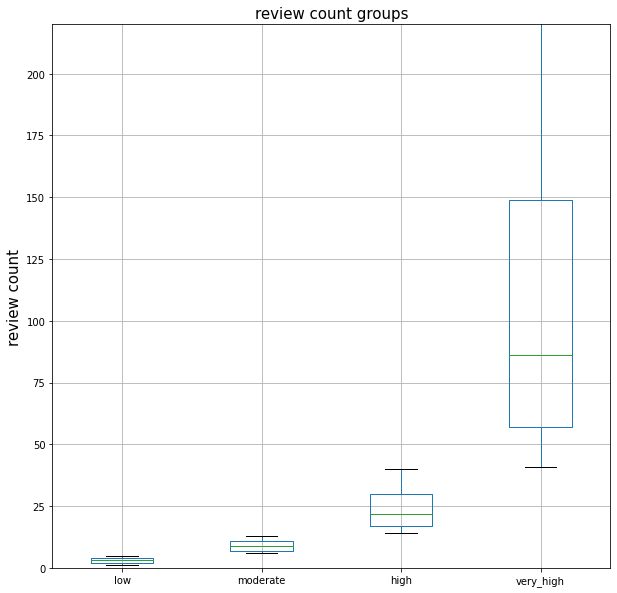

In [8]:
# --------------------------------------------------------------------------
#  Remove outliers for very high reviewers
# -------------------------------------------------------------------------- 

# Compute the number of outliers in the 'very_high' reviewers
Q1 = np.percentile(very_high_reviewers['review_count'], 25)
Q3 = np.percentile(very_high_reviewers['review_count'], 75)
IQR = Q3 - Q1
MAX = Q3 + (1.5 * IQR)

# Remove reviewers with review count above max
very_high_reviewers = very_high_reviewers[very_high_reviewers['review_count'] <= MAX]

# --------------------------------------------------------------------------
#  Review boxplots for review count groups
# -------------------------------------------------------------------------- 

# Create a boxplot for low, moderate, high, very high review count groups
count_boxplot = pd.DataFrame({
    'low': low_reviewers['review_count'],
    'moderate': moderate_reviewers['review_count'],
    'high': high_reviewers['review_count'],
    'very_high': very_high_reviewers['review_count']
})

# Boxplot settings
fig, (ax) = plt.subplots(1, 1, figsize=(10,  10))
count_boxplot.boxplot(ax=ax)
ax.set_ylabel('review count', fontdict={'fontsize': 15})
ax.set_title("review count groups", fontdict={'fontsize': 15})
plt.ylim([0, 220])
plt.show()


# What restaurant categories are frequently reviewed?
---
These four histograms plot how frequently users in each review count group (low, moderate, high, very high) are revieweing restaurant categories in Las Vegas.

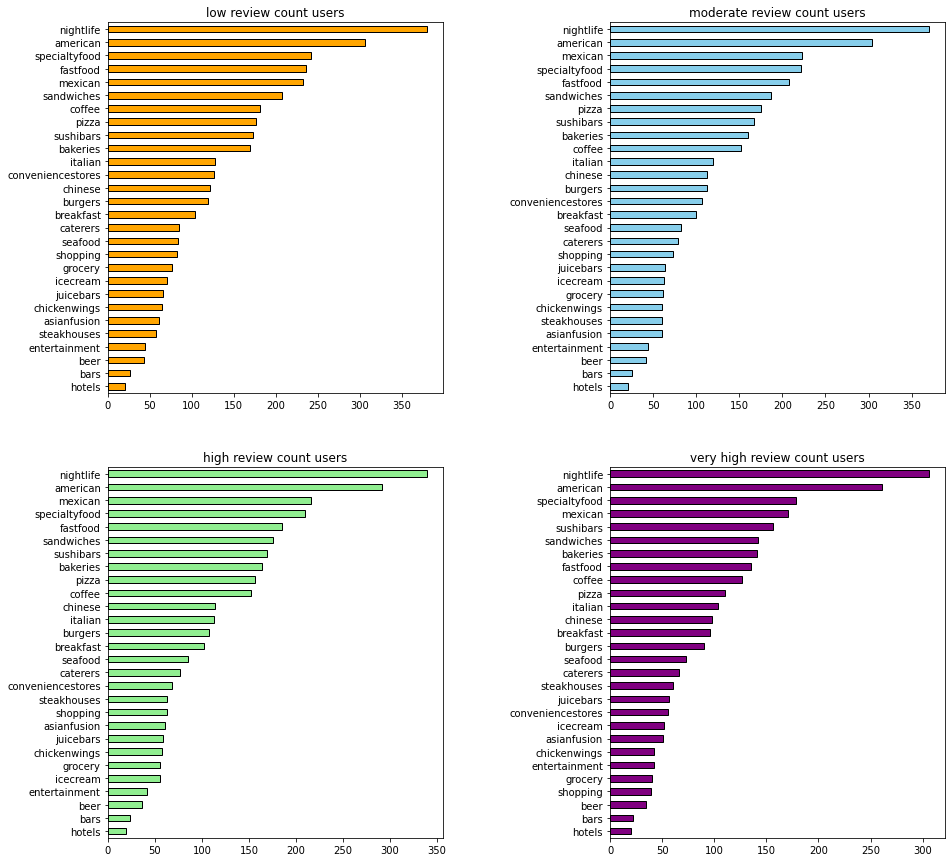

In [9]:
# --------------------------------------------------------------------------
#  Collect all resturant types reviewed by different review count users
# -------------------------------------------------------------------------- 

# Find business_id's reviewed by low, mod, high review count user_id's
low_business_ids = filtered_reviews[
    filtered_reviews['user_id'].isin(low_reviewers['user_id'])
]

moderate_business_ids = filtered_reviews[
    filtered_reviews['user_id'].isin(moderate_reviewers['user_id'])
]

high_business_ids = filtered_reviews.loc[
    filtered_reviews['user_id'].isin(high_reviewers['user_id'])
]

very_high_business_ids = filtered_reviews.loc[
    filtered_reviews['user_id'].isin(very_high_reviewers['user_id'])
]

# Find restaurants whose business id matches business id's reviewed by low, mod, high 
# review count users users
low_restaurant_types = labeledRestaurants.loc[
    labeledRestaurants['business_id'].isin(low_business_ids['business_id'])
]['restaurant_type']

moderate_restaurant_types = labeledRestaurants.loc[
    labeledRestaurants['business_id'].isin(moderate_business_ids['business_id'])
]['restaurant_type']

high_restaurant_types = labeledRestaurants.loc[
    labeledRestaurants['business_id'].isin(high_business_ids['business_id'])
]['restaurant_type']

very_high_restaurant_types = labeledRestaurants.loc[
    labeledRestaurants['business_id'].isin(very_high_business_ids['business_id'])
]['restaurant_type']


# Histogram settings
fig, ((ax, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(15,  15))
fig.subplots_adjust(wspace=0.5)

low_restaurant_types.value_counts().plot(ax=ax, kind='barh', color='orange', ec='black')
moderate_restaurant_types.value_counts().plot(ax=ax1, kind='barh', color='skyblue', ec='black')
high_restaurant_types.value_counts().plot(ax=ax2, kind='barh', color='lightgreen', ec='black')
very_high_restaurant_types.value_counts().plot(ax=ax3, kind='barh', color='purple', ec='black')

ax.set_title('low review count users')
ax1.set_title('moderate review count users')
ax2.set_title('high review count users')
ax3.set_title('very high review count users')

ax.invert_yaxis()
ax1.invert_yaxis()
ax2.invert_yaxis()
ax3.invert_yaxis()

plt.show()

# Are there dense clusters of good and mediocre restaurants?
---

The next cells will drill down on average star review by plotting the locations of restaurants with:

* good average star review (4 to 5) 
* mediocre average star review (0 to 3).

The intent is to locate locations where good and mediocre restaurant within specific categories might cluster.  

## Restaurant category locations
---
This code graphs the longitude and latitude of our labeled restaurant categories.

The restaurants category labels were generated using TF-IDF and K-means clustering (see restaurant category classification notebook).

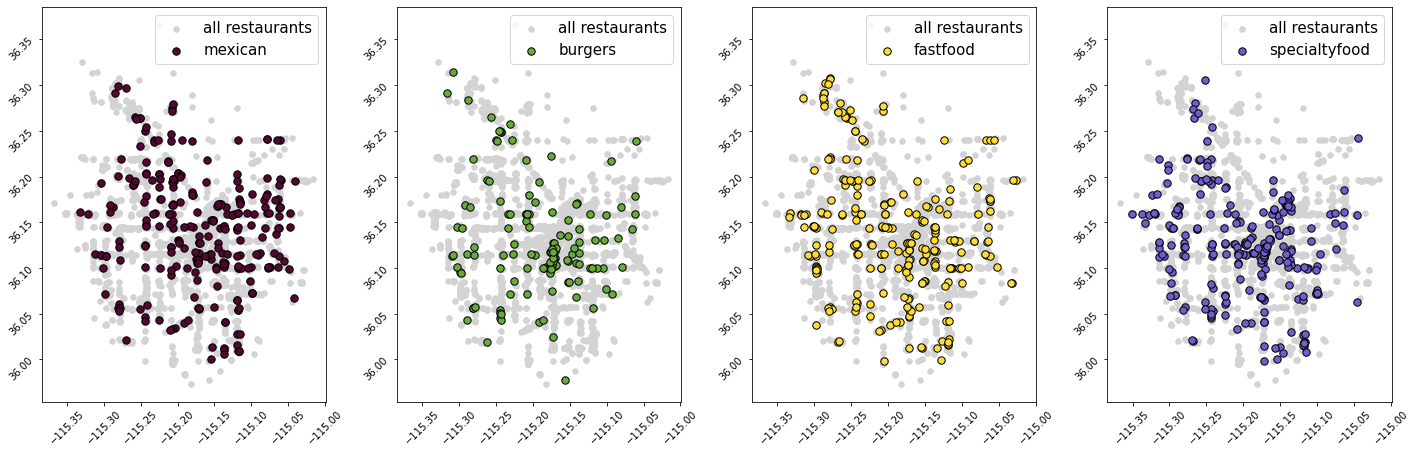

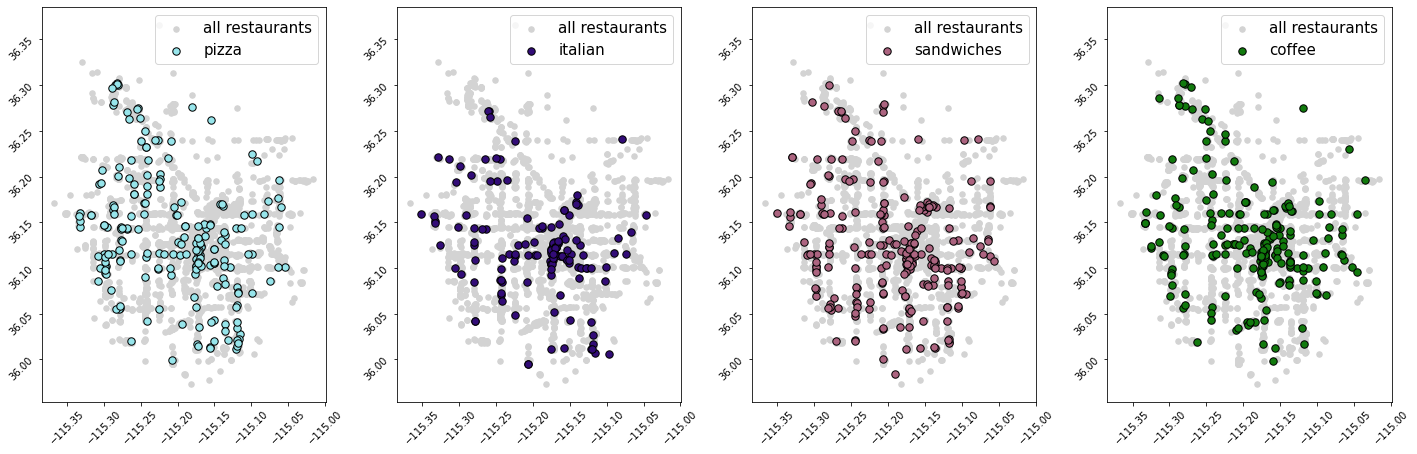

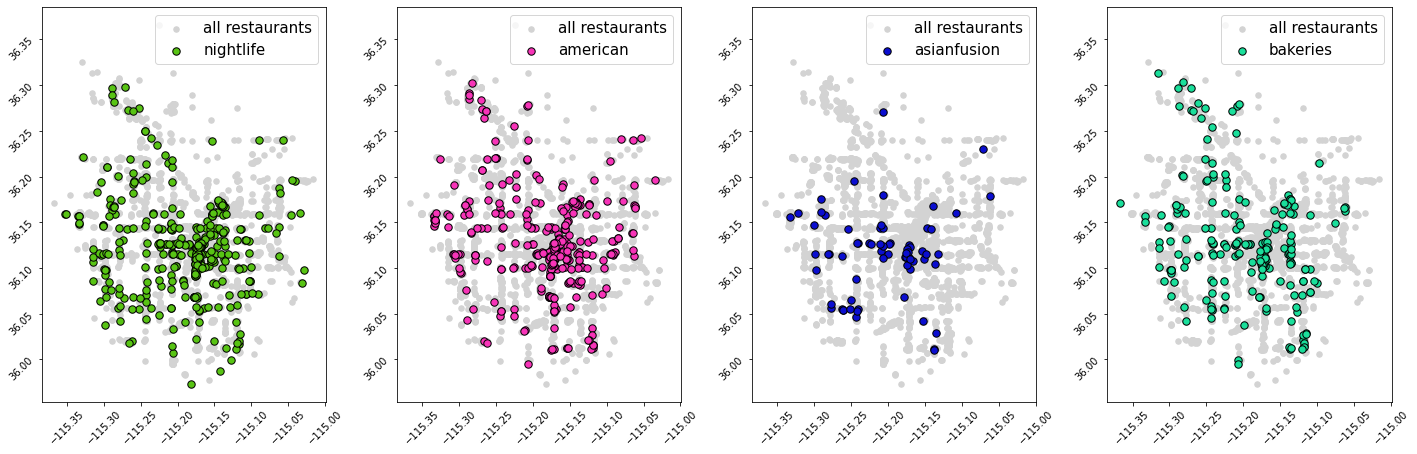

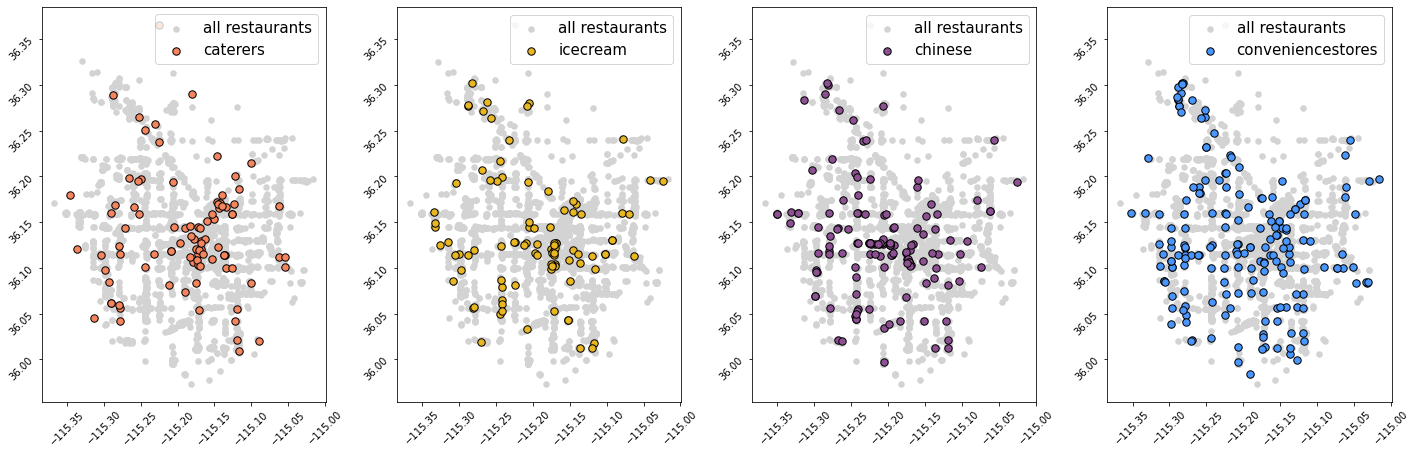

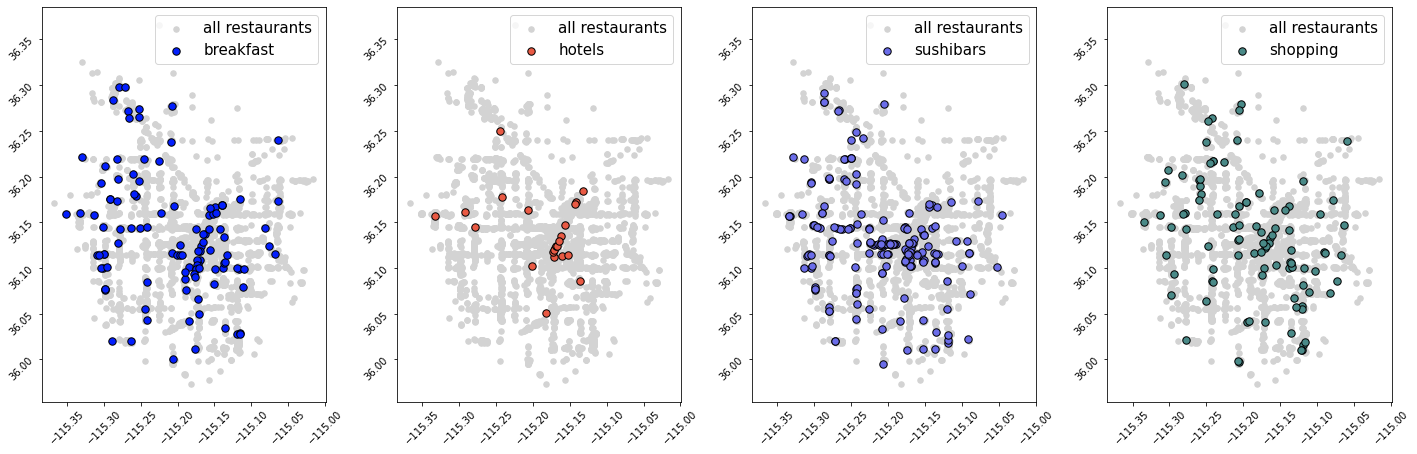

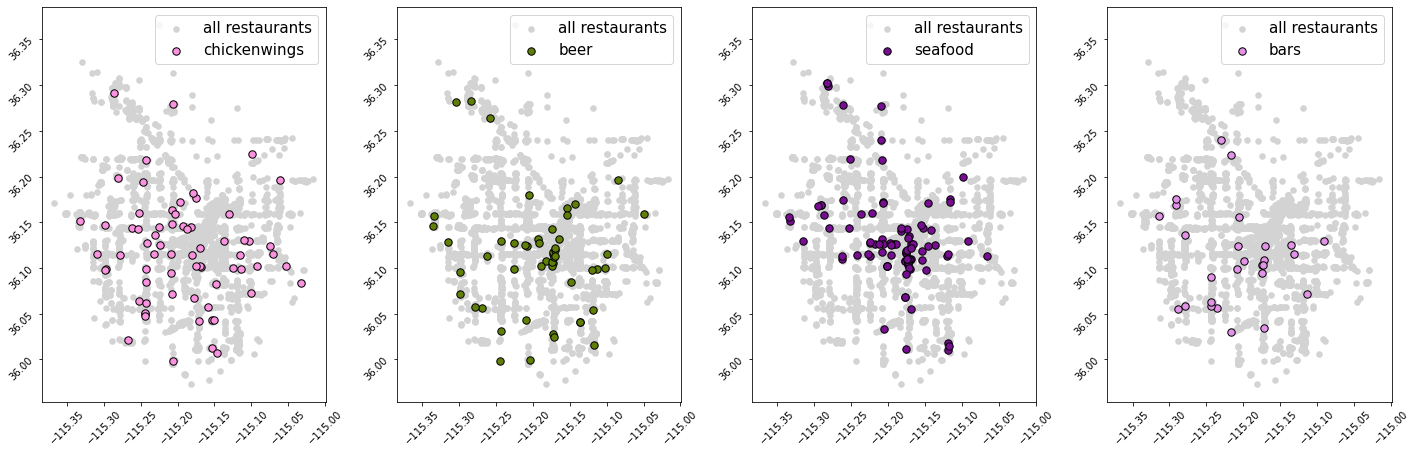

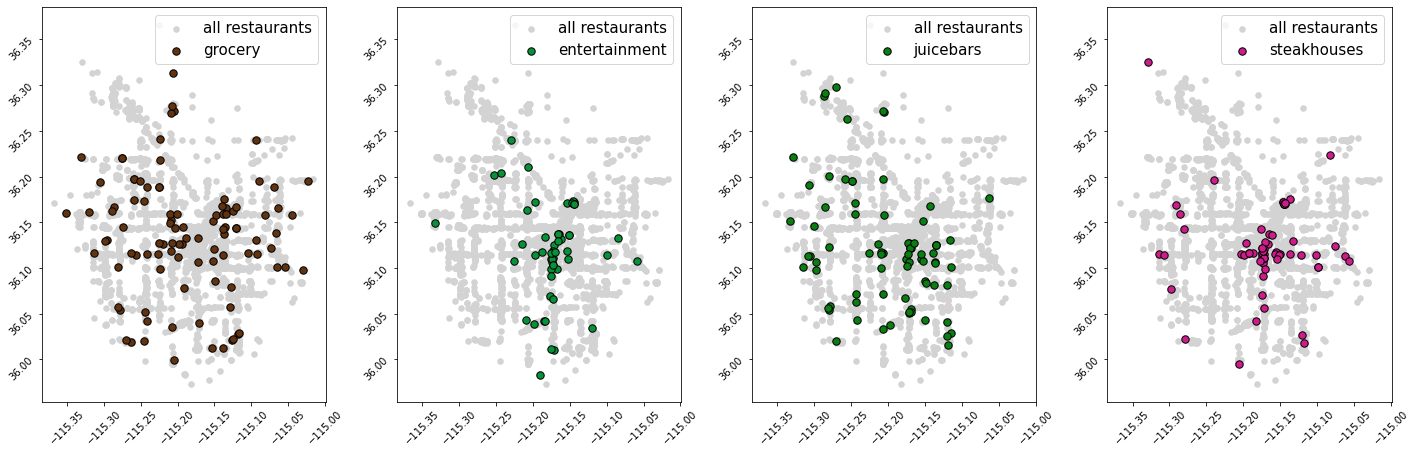

In [10]:
# --------------------------------------------------------------------------
#  Scatterplots of restaurant category longitudes and latitudes
# -------------------------------------------------------------------------- 

# List all unique restaurant category labels assigned to our dataset
categories = labeledRestaurants['restaurant_type'].unique()

geometry = [Point(xy) for xy in zip(labeledRestaurants['longitude'], labeledRestaurants['latitude'])]

# Create a geopandas dataframe and set coordinate reference system
gdf = gpd.GeoDataFrame(labeledRestaurants, crs='EPSG:4326', geometry=geometry)

# Plot business category locations (4 business categories per row)
for i in range(0, len(categories) - 1, 4):
    fig, ((ax, ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=4, figsize=(10, 20))
    fig.subplots_adjust(right=2, wspace=0.25, hspace=0.75)

    gdf.plot(ax=ax, marker='o', markersize=30, color='lightgrey', figsize=(10,10), label='all restaurants')
    gdf.plot(ax=ax1, marker='o', markersize=30, color='lightgrey', figsize=(10,10), label='all restaurants')
    gdf.plot(ax=ax2, marker='o', markersize=30, color='lightgrey', figsize=(10,10), label='all restaurants')
    gdf.plot(ax=ax3, marker='o', markersize=30, color='lightgrey', figsize=(10,10), label='all restaurants')

    gdf[gdf['restaurant_type'] == categories[i]].plot(ax=ax, markersize=55, color=np.random.rand(3,), marker='o', label=categories[i], ec='black')
    gdf[gdf['restaurant_type'] == categories[i+1]].plot(ax=ax1, markersize=55, color=np.random.rand(3,), marker='o', label=categories[i+1], ec='black')
    gdf[gdf['restaurant_type'] == categories[i+2]].plot(ax=ax2, markersize=55, color=np.random.rand(3,), marker='o', label=categories[i+2], ec='black')
    gdf[gdf['restaurant_type'] == categories[i+3]].plot(ax=ax3, markersize=55, color=np.random.rand(3,), marker='o', label=categories[i+3], ec='black')
    
    ax.legend(prop={'size': 15})
    ax1.legend(prop={'size': 15})
    ax2.legend(prop={'size': 15})
    ax3.legend(prop={'size': 15})
    
    ax.tick_params(labelrotation=45)
    ax1.tick_params(labelrotation=45)
    ax2.tick_params(labelrotation=45)
    ax3.tick_params(labelrotation=45)

## Restaurant category locations with good (4-5) and mediocre (0-3) average star reviews
---
This code drills down on avg star review. It graphs the graphs the longitude and latitude of our labeled restaurant categories, separated into two groups:

* Mediocre average star review (0 to 3)
* Good average star review (4 to 5)

The restaurants category labels were generated using TF-IDF and K-means clustering (see restaurant category classification notebook).

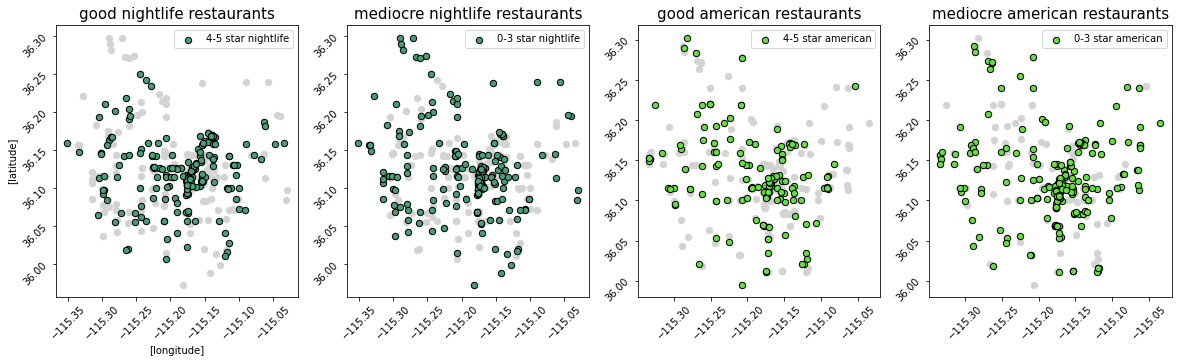

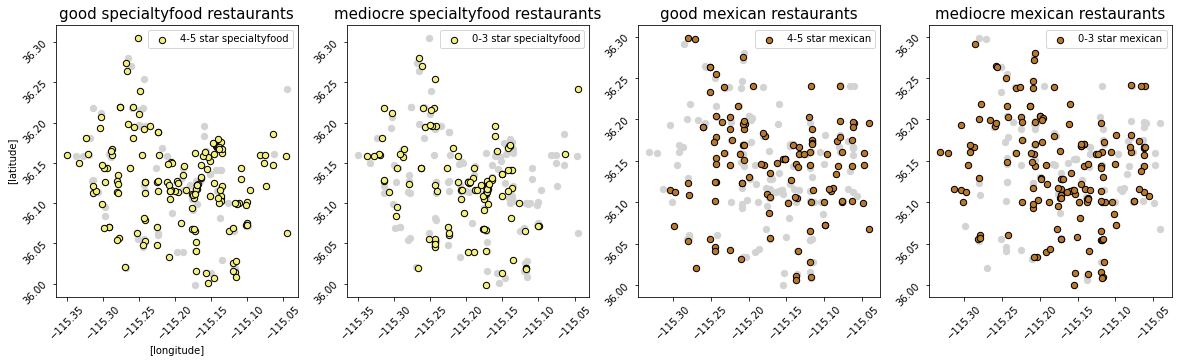

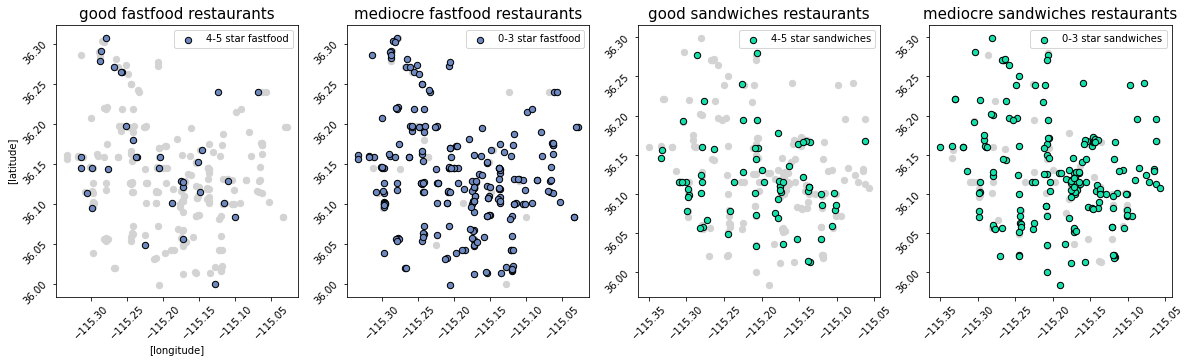

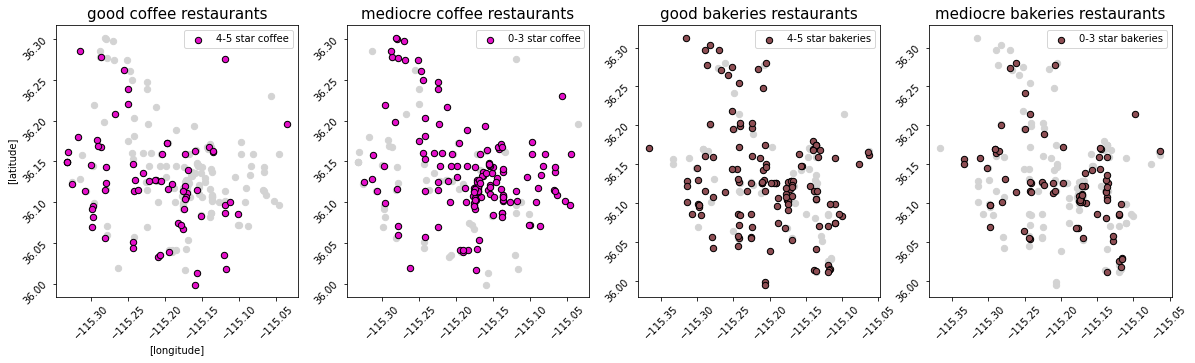

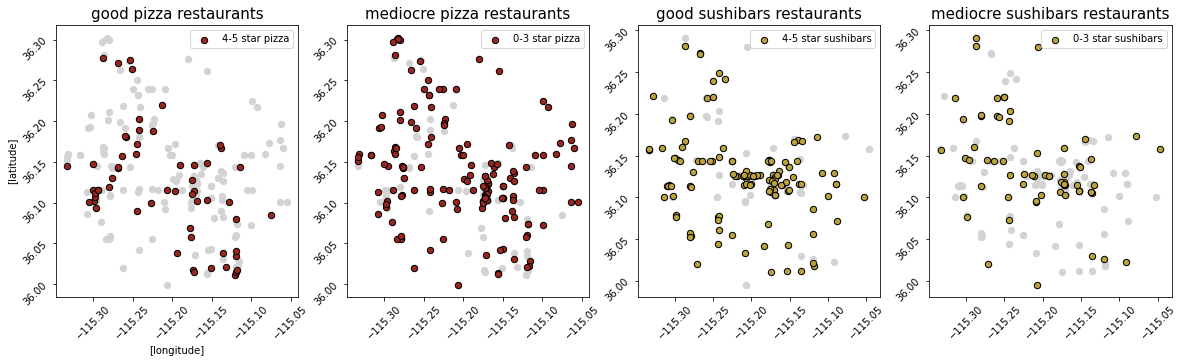

In [17]:
#------------------------------------------------------------------------------------
#  Scatterplots of good and mediocre restaurant category longitudes and latitudes
#------------------------------------------------------------------------------------

# List the top ten restaurant category labels and put it into a dataframe
top_ten_categories = labeledRestaurants['restaurant_type'].value_counts()[:10]
category_df = top_ten_categories.rename_axis('category').reset_index(name='counts')
category_list = category_df['category'].to_list()

# Index labeledRestaurants using 'restaurant_type' and 'category' from category_df, get: longitude, latitude, stars
for i, j in zip(category_list[0::2], category_list[1::2]):
    
    # use the category to collect the restaurants from 'labeledRestaurants'
    restaurants_in_category_1 = labeledRestaurants.loc[labeledRestaurants['restaurant_type'] == i]
    restaurants_in_category_2 = labeledRestaurants.loc[labeledRestaurants['restaurant_type'] == j]
    
    # Get the longitudes, latitudes, stars of the restaurants from the category
    locations_1 = restaurants_in_category_1[['longitude', 'latitude', 'stars']]
    locations_2 = restaurants_in_category_2[['longitude', 'latitude', 'stars']]
    
    # Split restaurants on star rating: 0 to 4 is mediocre, 4 to 5 is good
    good_locations_1 = locations_1[(locations_1['stars'] >= 4) & (locations_1['stars'] <= 5)]
    mediocre_locations_1 = locations_1[(locations_1['stars'] >= 0) & (locations_1['stars'] < 4)]
    good_locations_2 = locations_2[(locations_2['stars'] >= 4) & (locations_2['stars'] <= 5)]
    mediocre_locations_2 = locations_2[(locations_2['stars'] >= 0) & (locations_2['stars'] < 4)]
    
    # Plot the locations of the mediocre and good restaurant categories
    fix, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
    fig.subplots_adjust(right=2, wspace=0.25, hspace=0.75)
    
    locations_1.plot.scatter(ax=axes[0], x=['longitude'], y=['latitude'], s=40, marker='o', color='lightgrey')
    locations_1.plot.scatter(ax=axes[1], x=['longitude'], y=['latitude'], s=40, marker='o', color='lightgrey')
    locations_2.plot.scatter(ax=axes[2], x=['longitude'], y=['latitude'], s=40, marker='o', color='lightgrey')
    locations_2.plot.scatter(ax=axes[3], x=['longitude'], y=['latitude'], s=40, marker='o', color='lightgrey')
    
    color_1, color_2 = np.array([np.random.rand(3,)]), np.array([np.random.rand(3,)])
    good_locations_1.plot.scatter(x=['longitude'], y=['latitude'], s=40, c=color_1, marker='o', ec='black', ax=axes[0], label=f'4-5 star {i}')
    mediocre_locations_1.plot.scatter(x=['longitude'], y=['latitude'], s=40, c=color_1, marker='o', ec='black', ax=axes[1], label=f'0-3 star {i}')
    good_locations_2.plot.scatter(x=['longitude'], y=['latitude'], s=40, c=color_2, marker='o', ec='black', ax=axes[2], label=f'4-5 star {j}')
    mediocre_locations_2.plot.scatter(x=['longitude'], y=['latitude'], s=40, c=color_2, marker='o', ec='black', ax=axes[3], label=f'0-3 star {j}')
    
    #------------------------------------------------------------------------------------
    #  General graph settings
    #------------------------------------------------------------------------------------
    
    axes[0].set_title(f'good {i} restaurants', fontdict={'fontsize': 15})
    axes[1].set_title(f'mediocre {i} restaurants', fontdict={'fontsize': 15})
    axes[2].set_title(f'good {j} restaurants', fontdict={'fontsize': 15})
    axes[3].set_title(f'mediocre {j} restaurants', fontdict={'fontsize': 15})
    
    axes[0].tick_params(labelrotation=45)
    axes[1].tick_params(labelrotation=45)
    axes[2].tick_params(labelrotation=45)
    axes[3].tick_params(labelrotation=45)
    
    axes[1].xaxis.label.set_visible(False)
    axes[1].yaxis.label.set_visible(False)
    axes[2].xaxis.label.set_visible(False)
    axes[2].yaxis.label.set_visible(False)
    axes[3].xaxis.label.set_visible(False)
    axes[3].yaxis.label.set_visible(False)

## Use DBSCAN to identify dense clusters of good and mediocre restaurants
---
This code uses density-based spatial clustering (DBSCAN) to identify dense locations of good and mediocre average star reviewed restaurants.

Each scatter plot has labels:

* **Red**: clusters identified by DBSCAN

* **Black**: outliers

There may be multiple distinct clusters in each graph, however for simplicity in this visualization I labeled all clusters identified by DBSCAN the same. 

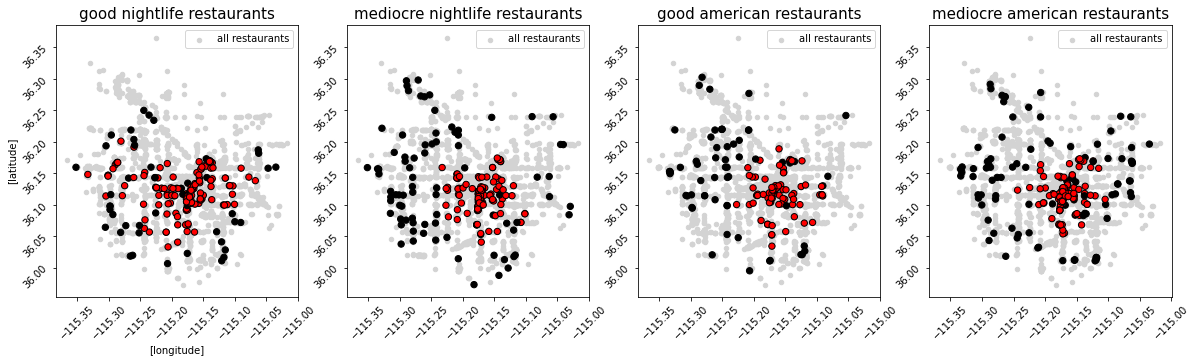

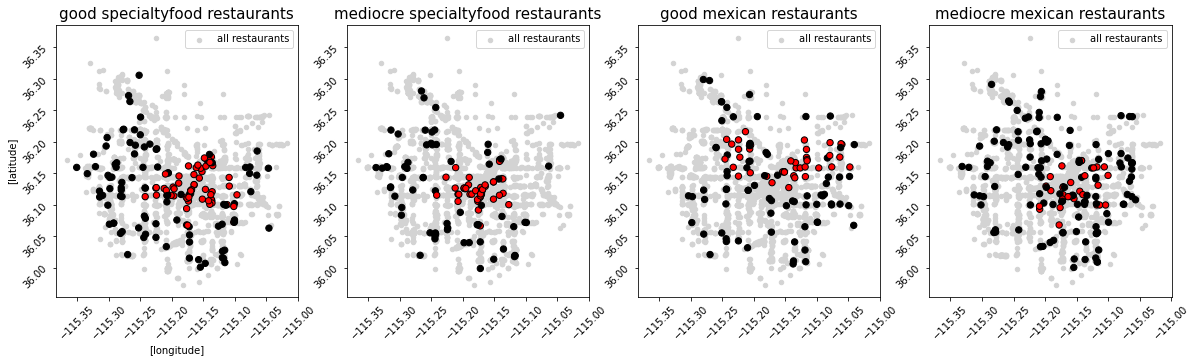

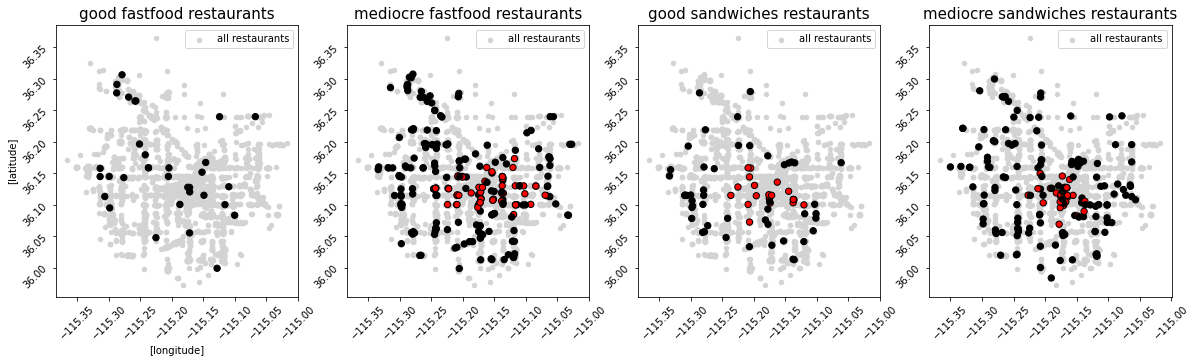

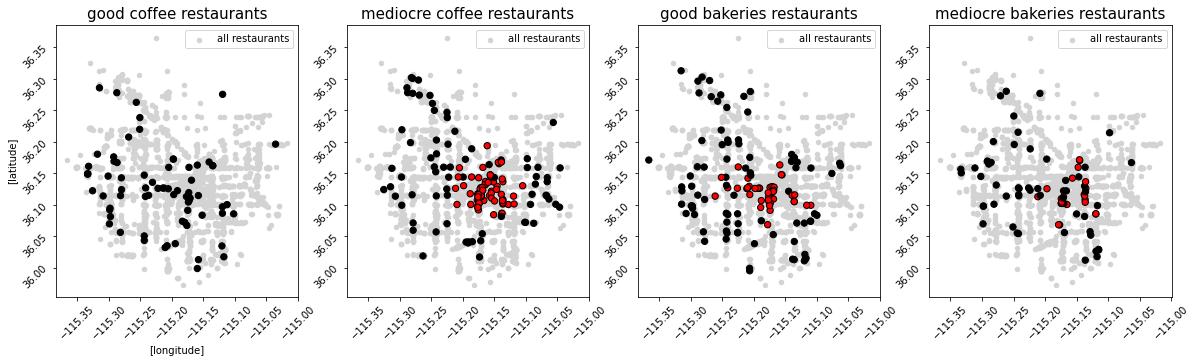

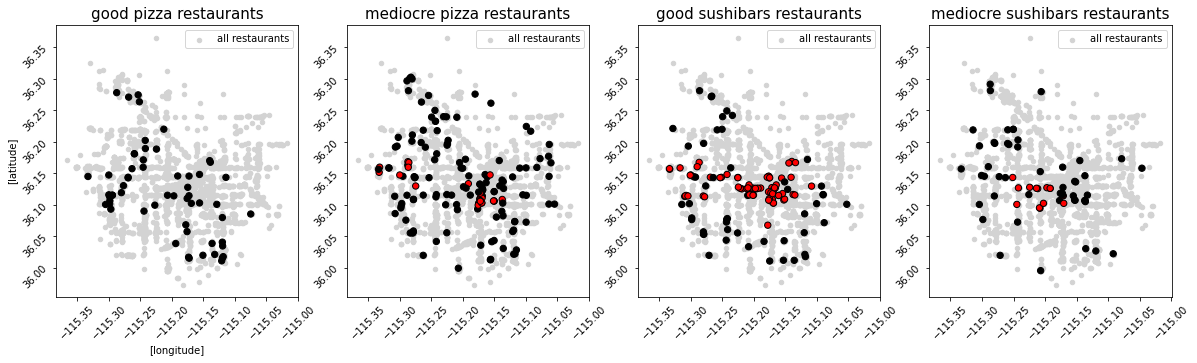

In [12]:
#------------------------------------------------------------------------------------
#  Run DBSCAN to identify dense clusters of good and mediocre restaurants
#------------------------------------------------------------------------------------

# List the top ten restaurant category labels and put it into a dataframe
top_ten_categories = labeledRestaurants['restaurant_type'].value_counts()[:10]
category_df = top_ten_categories.rename_axis('category').reset_index(name='counts')
category_list = category_df['category'].to_list()

# Index labeledRestaurants using 'restaurant_type' and 'category' from category_df, get: longitude, latitude, stars
for i, j in zip(category_list[0::2], category_list[1::2]):
    
    # use the category to collect the restaurants from 'labeledRestaurants'
    restaurants_in_category_1 = labeledRestaurants.loc[labeledRestaurants['restaurant_type'] == i]
    restaurants_in_category_2 = labeledRestaurants.loc[labeledRestaurants['restaurant_type'] == j]
    
    # Get the longitudes, latitudes, stars of the restaurants from the category
    locations_1 = restaurants_in_category_1[['longitude', 'latitude', 'stars']]
    locations_2 = restaurants_in_category_2[['longitude', 'latitude', 'stars']]
    
    # Split restaurants on star rating: 0 to 4 is mediocre, 4 to 5 is good
    good_locations_1 = locations_1[(locations_1['stars'] >= 4) & (locations_1['stars'] <= 5)]
    mediocre_locations_1 = locations_1[(locations_1['stars'] >= 0) & (locations_1['stars'] < 4)]
    good_locations_2 = locations_2[(locations_2['stars'] >= 4) & (locations_2['stars'] <= 5)]
    mediocre_locations_2 = locations_2[(locations_2['stars'] >= 0) & (locations_2['stars'] < 4)]
    
    #------------------------------------------------------------------------------------
    #  Run DBSCAN (epsilon = 0.0375) on good and mediocre restaurant locations
    #------------------------------------------------------------------------------------
    
    # Run DBSCAN on good and mediocre locations
    DBSCAN_good_locations_1 = DBSCAN(eps=0.0375, min_samples=10).fit(good_locations_1)
    DBSCAN_mediocre_locations_1 = DBSCAN(eps=0.0375, min_samples=10).fit(mediocre_locations_1)
    DBSCAN_good_locations_2 = DBSCAN(eps=0.0375, min_samples=10).fit(good_locations_2)
    DBSCAN_mediocre_locations_2 = DBSCAN(eps=0.0375, min_samples=10).fit(mediocre_locations_2)
    
    # Collect the DBSCAN cluster labels
    labels_good_1 = DBSCAN_good_locations_1.labels_
    labels_mediocre_1 = DBSCAN_mediocre_locations_1.labels_
    labels_good_2 = DBSCAN_good_locations_2.labels_
    labels_mediocre_2 = DBSCAN_mediocre_locations_2.labels_

    # Number of clusters found by DBSCAN
    n_clusters_good_1 = len(set(labels_good_1)) - (1 if -1 in labels_good_1 else 0)
    n_clusters_mediocre_1 = len(set(labels_mediocre_1)) - (1 if -1 in labels_mediocre_1 else 0)
    n_clusters_good_2 = len(set(labels_good_2)) - (1 if -1 in labels_good_2 else 0)
    n_clusters_mediocre_2 = len(set(labels_mediocre_2)) - (1 if -1 in labels_mediocre_2 else 0)
    
    # Outlier points found by DBSCAN
    n_outliers_good_1 = list(labels_good_1).count(-1)
    n_outliers_mediocre_1 = list(labels_mediocre_1).count(-1)
    n_outliers_good_2 = list(labels_good_2).count(-1)
    n_outliers_mediocre_2 = list(labels_mediocre_2).count(-1)
    
    #------------------------------------------------------------------------------------
    #  Create subplots and graph each restaurant location (grey) and DBSCAN results
    #------------------------------------------------------------------------------------ 
    
    # label color mapping
    color_list = []
    label_list = [labels_good_1, labels_mediocre_1, labels_good_2, labels_mediocre_2]
    for labels in label_list:
        colors = ['black' if x == -1 else 'red' for x in labels]
        color_list.append(colors)
    
    # Plot the locations of the mediocre and good restaurant categories
    fix, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
    fig.subplots_adjust(right=2, wspace=0.25, hspace=0.75)
    
    # Plot all locations as grey
    labeledRestaurants.plot.scatter(ax=axes[0], x=['longitude'], y=['latitude'], marker='o', color='lightgrey', label='all restaurants')
    labeledRestaurants.plot.scatter(ax=axes[1], x=['longitude'], y=['latitude'], marker='o', color='lightgrey', label='all restaurants')
    labeledRestaurants.plot.scatter(ax=axes[2], x=['longitude'], y=['latitude'], marker='o', color='lightgrey', label='all restaurants')
    labeledRestaurants.plot.scatter(ax=axes[3], x=['longitude'], y=['latitude'], marker='o', color='lightgrey', label='all restaurants')
    
    # Plot good or mediocre locations using the DBSCAN cluster color mapping
    good_locations_1.plot.scatter(x=['longitude'], y=['latitude'], s=40, c=color_list[0], marker='o', ec='black', ax=axes[0])
    mediocre_locations_1.plot.scatter(x=['longitude'], y=['latitude'], s=40, c=color_list[1], ec='black', marker='o', ax=axes[1])
    good_locations_2.plot.scatter(x=['longitude'], y=['latitude'], s=40, c=color_list[2], marker='o', ec='black', ax=axes[2])
    mediocre_locations_2.plot.scatter(x=['longitude'], y=['latitude'], s=40, c=color_list[3], marker='o', ec='black', ax=axes[3])
    
    #------------------------------------------------------------------------------------
    #  General graph settings
    #------------------------------------------------------------------------------------   
    
    # Title set
    axes[0].set_title(f'good {i} restaurants', fontdict={'fontsize': 15})
    axes[1].set_title(f'mediocre {i} restaurants', fontdict={'fontsize': 15})
    axes[2].set_title(f'good {j} restaurants', fontdict={'fontsize': 15})
    axes[3].set_title(f'mediocre {j} restaurants', fontdict={'fontsize': 15})
    
    # Axes rotation
    axes[0].tick_params(labelrotation=45)
    axes[1].tick_params(labelrotation=45)
    axes[2].tick_params(labelrotation=45)
    axes[3].tick_params(labelrotation=45)
    
    # Axes hide
    axes[1].xaxis.label.set_visible(False)
    axes[1].yaxis.label.set_visible(False)
    axes[2].xaxis.label.set_visible(False)
    axes[2].yaxis.label.set_visible(False)
    axes[3].xaxis.label.set_visible(False)
    axes[3].yaxis.label.set_visible(False)

## DBSCAN results
---
This code prints the results of running DBSCAN for our good and mediocre restaurant categories. 

The output includes the number of clusters detected for each category, and the number of outliers excluded. 

**Note:** some graphs may have several clusters. However, in the above visualization, all clusters are labeled red.

In [281]:
#------------------------------------------------------------------------------------
#  Print the number of clusters and outliers found  DBSCAN
#------------------------------------------------------------------------------------ 
for i, j in zip(category_list[0::2], category_list[1::2]):
    print(f"""
    [{i}]: good clusters: {n_clusters_good_1}, mediocre clusters: {n_clusters_mediocre_1}
    [{i}]: good outlier points: {n_outliers_good_1}, mediocre outlier points: {n_outliers_mediocre_1}
    {'--'*40}
    [{j}]: good clusters: {n_clusters_good_2}, mediocre clusters: {n_clusters_mediocre_2}
    [{j}]: good outlier points: {n_outliers_good_2}, mediocre outlier points: {n_outliers_mediocre_2}
    {'--'*40}
""")


    [nightlife]: good clusters: 0, mediocre clusters: 2
    [nightlife]: good outlier points: 58, mediocre outlier points: 127
    --------------------------------------------------------------------------------
    [american]: good clusters: 3, mediocre clusters: 1
    [american]: good outlier points: 52, mediocre outlier points: 50
    --------------------------------------------------------------------------------


    [specialtyfood]: good clusters: 0, mediocre clusters: 2
    [specialtyfood]: good outlier points: 58, mediocre outlier points: 127
    --------------------------------------------------------------------------------
    [mexican]: good clusters: 3, mediocre clusters: 1
    [mexican]: good outlier points: 52, mediocre outlier points: 50
    --------------------------------------------------------------------------------


    [fastfood]: good clusters: 0, mediocre clusters: 2
    [fastfood]: good outlier points: 58, mediocre outlier points: 127
    ------------------